In [211]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
import numpy as np
import pandas as pd
from src.bioreactor import mpc, plot_results, evaluation, generate_training_data, model_predict, simulate
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

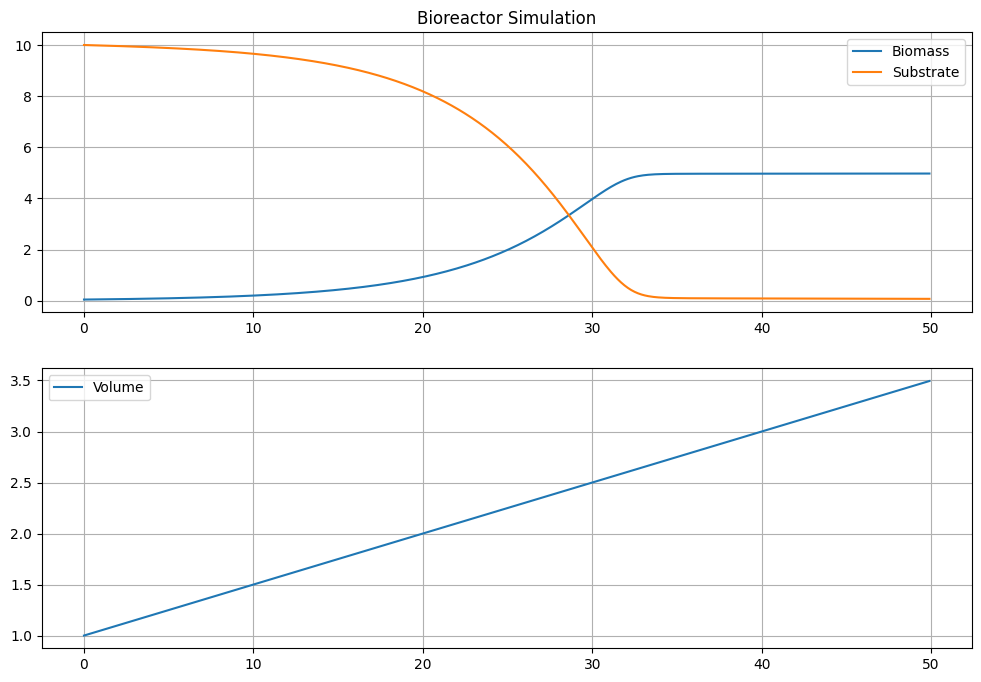

In [213]:
sol = simulate(0.05, plot=True)

In [214]:
# X_train, y_train = generate_training_data()

# model = GradientBoostingRegressor().fit(X_train, y_train)
# model_predict(X_train[0][0], X_train[0][1], X_train[0][2], X_train[0][3], model)

In [215]:
X, S, V, F = mpc(model='discretized')
# X, S, V, F = mpc(model)

  5%|▌         | 26/500 [00:00<00:01, 251.84it/s]

100%|██████████| 500/500 [00:01<00:00, 308.22it/s]


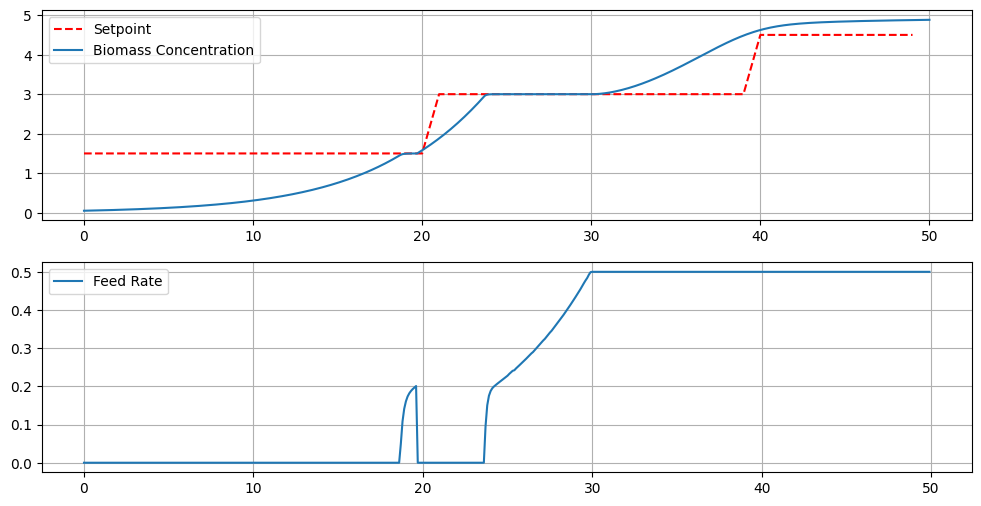

In [216]:
plot_results(X, F)

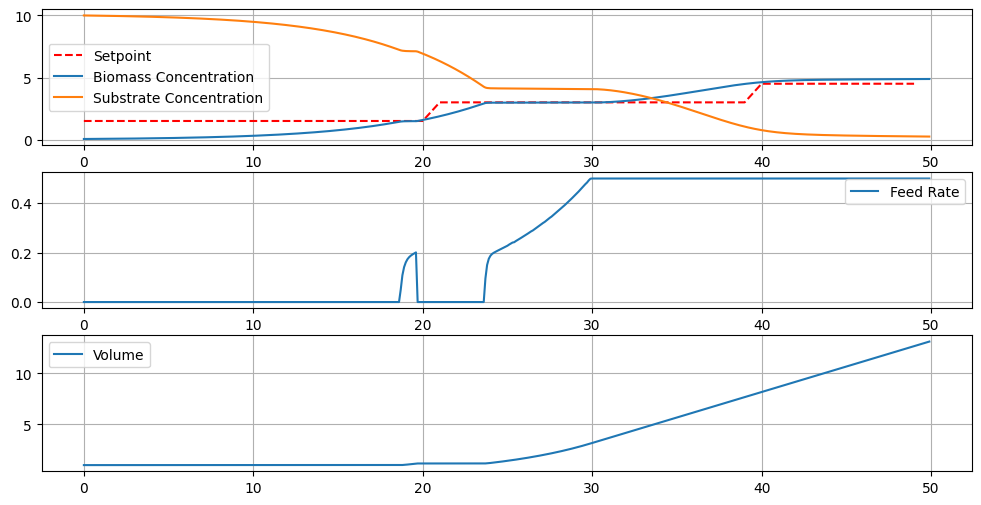

In [217]:
evaluation(F)